In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
# Simple model of tumor growth
# Assume a patient with stage IV kidney cancer that was 15.5cm x 15cm at diagnosis
# Assume tumors grow at constant doubling time, and are roughly spherical

# Define t1 as time when patient retired from military, t2 as time of diagnosis
# t2 - r1 = about 9.0 years
# Assume tumor was 1cm at t1, estimate size at t2

# A function to compute the volume of a sphere

def calc_volume(diameter):
    """Converts diameter to a volume"""
    factor = 4 * np.pi / 3
    return factor * (diameter/2.0)**3

In [6]:
# Tumor volume at t1

d1 = 1
v1 = calc_volume(d1)
v1

0.5235987755982988

In [7]:
# Median doubling time of 811 days comes from a paper

median_doubling_time = 811
rdt = 365 / median_doubling_time
rdt

0.45006165228113443

In [8]:
# Compute the number of doublings between t1 and t2

interval = 9.0
doublings = interval * rdt
doublings

4.05055487053021

In [9]:
# Volume at t2

v2 = v1 * 2**doublings
v2

8.676351488087187

In [10]:
# This function computes the diameter of a sphere given a volume

def calc_diameter(volume):
    """Computes a diameter from a volume"""
    factor = 3 / np.pi / 4
    return 2 * (factor*volume)**(1/3)

In [11]:
# Diameter of the tumor at t2

d2 = calc_diameter(v2)
d2

2.5494480788327483

In [12]:
# This model demonstrates tumor growth, but doesn't answer the question
# With a tumor of given size, what is the  distribution of its age
# So we'll run simulations of tumor growth to get a distribution of size conditioned on age
# Then compute the distribution of age conditioned on size
# RDT estimates for the 53 patients in the study come from Zhang et al. paper

rdts = [5.089,  3.572,  3.242,  2.642,  1.982,  1.847,  1.908,  1.798,
        1.798,  1.761,  2.703, -0.416,  0.024,  0.869,  0.746,  0.257,
        0.269,  0.086,  0.086,  1.321,  1.052,  1.076,  0.758,  0.587,
        0.367,  0.416,  0.073,  0.538,  0.281,  0.122, -0.869, -1.431,
        0.012,  0.037, -0.135,  0.122,  0.208,  0.245,  0.404,  0.648,
        0.673,  0.673,  0.563,  0.391,  0.049,  0.538,  0.514,  0.404,
        0.404,  0.33,  -0.061,  0.538,  0.306]

rdt_sample = np.array(rdts)
len(rdt_sample)

53

In [13]:
from empiricaldist import Pmf
from scipy.stats import gaussian_kde

In [14]:
def kde_from_sample(sample, qs):
    """Make a kernel density estimate from a sample."""
    kde = gaussian_kde(sample)
    ps = kde(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [15]:
# Use the sample of RDTs to estimate PDF

qs = np.linspace(-2, 6, num=201)
pmf_rdt = kde_from_sample(rdt_sample, qs)

<Axes: title={'center': 'Distribution of growth rates'}, xlabel='Reciprocal doubling time (RDT)', ylabel='PDF'>

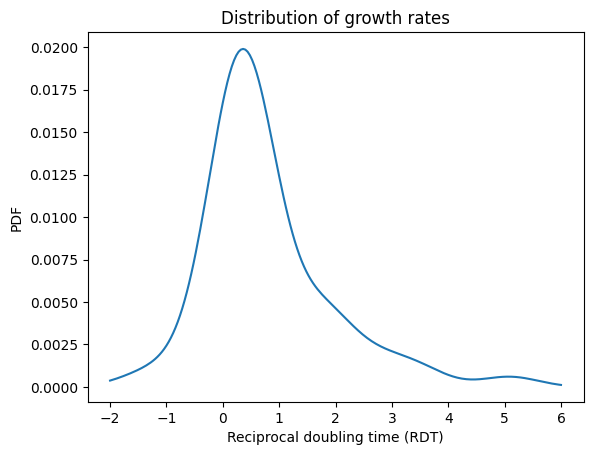

In [16]:
pmf_rdt.plot(title='Distribution of growth rates', xlabel='Reciprocal doubling time (RDT)', ylabel='PDF')

In [17]:
# We'll use this distribution to simulate tumor growth: simulate a series of intervals until a tumor reaches a max size
# We choose an interval of 245 days based on the median time in the data source
# Based on other data we choose 0.3cm as the min diameter and 20cm as the max

interval = 245/365
min_diameter = 0.3
max_diameter = 20

# calc_volume used to compute initial and max volumes

v0 = calc_volume(min_diameter)
vmax = calc_volume(max_diameter)
v0, vmax

(0.014137166941154066, 4188.790204786391)

In [18]:
# This function runs the simulation

def simulate_growth(pmf_rdt):
    """Simulate the growth of a tumor."""
    age = 0
    volume = v0
    res = []
    
    while True:
        res.append((age, volume))
        if volume > vmax:
            break

        rdt = pmf_rdt.choice()
        age += interval 
        doublings = rdt * interval
        volume *= 2**doublings
        
    columns = ['age', 'volume']
    sim = pd.DataFrame(res, columns=columns)
    sim['diameter'] = calc_diameter(sim['volume'])
    return sim

# THIS DOESN'T WORK

In [19]:
sim = simulate_growth(pmf_rdt)
sim.head()

,age,volume,diameter
0,0.000000,0.014137,0.3
1,0.671233,[6309.491742731578],[22.926191621568222]
2,1.342466,[6309.491742731578],[22.926191621568222]
3,2.013699,[6309.491742731578],[22.926191621568222]
4,2.684932,[6309.491742731578],[22.926191621568222]


In [26]:
sim.tail()

,age,volume,diameter
19,12.753425,[6078.962690616232],[22.643503235067385]
20,13.424658,[6078.962690616232],[22.643503235067385]
21,14.095890,[6078.962690616232],[22.643503235067385]
22,14.767123,[6078.962690616232],[22.643503235067385]
23,15.438356,[6078.962690616232],[22.643503235067385]


In [27]:
# Run 101 iterations
sims = [simulate_growth(pmf_rdt) for _ in range(101)]

([<matplotlib.axis.YTick at 0x7f0d6b73d990>,
 [Text(0, 0.2, '0.2'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20')])

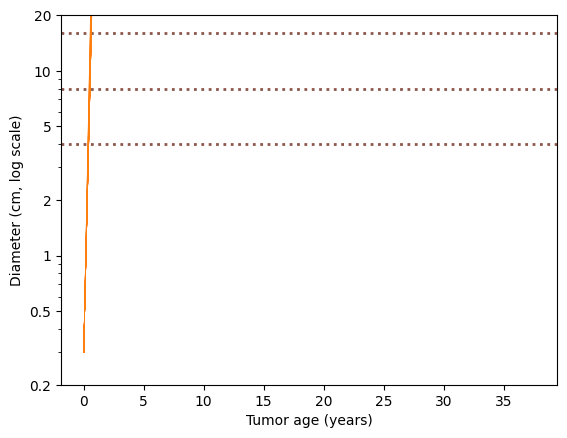

In [28]:
diameters = [4, 8, 16]
for diameter in diameters:
    plt.axhline(diameter, color='C5', linewidth=2, ls=':')
    
for sim in sims:
    plt.plot(sim['age'], sim['diameter'], color='C1', linewidth=0.5, alpha=0.5)
    
plt.xlabel('Tumor age (years)')
plt.ylabel('Diameter (cm, log scale)')
plt.ylim([0.2, 20])
plt.yscale('log')
yticks = [0.2, 0.5, 1, 2, 5, 10, 20]
plt.yticks(yticks, yticks)

In [20]:
# I guess we'll move on to the next example

total_squares = 25
squares_counted = 5
yeast_counted = 49

# The 1st part of the model defines yeast concentration

import pymc as pm

In [23]:
billion = 1e9

with pm.Model() as model:
    yeast_conc = pm.Normal('yeast_conc', mu=2 * billion, sigma=0.4 * billion)
    
    shaker1_vol = pm.Normal('shaker1_vol', mu=9.0, sigma=0.05)
    shaker2_vol = pm.Normal('shaker2_vol', mu=9.0, sigma=0.05)
    shaker3_vol = pm.Normal('shaker3_vol', mu=9.0, sigma=0.05)

In [24]:
with model:
    yeast_slurry_vol = pm.Normal('yeast_slurry_vol', mu=1.0, sigma=0.01)
    shaker1_to_shaker2_vol = pm.Normal('shaker1_to_shaker2_vol', mu=1.0, sigma=0.01)
    shaker2_to_shaker3_vol = pm.Normal('shaker2_to_shaker3_vol', mu=1.0, sigma=0.01)

In [25]:
with model:
    dilution_shaker1 = (yeast_slurry_vol / (yeast_slurry_vol + shaker1_vol))
    dilution_shaker2 = (shaker1_to_shaker2_vol / (shaker1_to_shaker2_vol + shaker2_vol))
    dilution_shaker3 = (shaker2_to_shaker3_vol / (shaker2_to_shaker3_vol + shaker3_vol))
    
    final_dilution = (dilution_shaker1 * dilution_shaker2 * dilution_shaker3)

In [27]:
with model:
    chamber_vol = pm.Gamma('chamber_vol', mu=0.0001, sigma=0.0001/20)

In [28]:
with model:
    yeast_in_chamber = pm.Poisson('yeast_in_chamber', mu = yeast_conc * final_dilution * chamber_vol)

In [29]:
with model:
    count = pm.Binomial('count', n=yeast_in_chamber, p=squares_counted/total_squares, observed=yeast_counted)

In [30]:
options = dict(return_inferencedata=False)

with model:
    trace = pm.sample(1000, **options)

                               Step       Grad                          Accept     Sampling                       
  Progress   Draws   Diverge…   size       evals      Tuning   Scaling   Rate       Speed      Elapsed   Remaini…  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━   2000    0          1.25       3          False    32.21     0.00       279.20     0:00:07   0:00:00   
                                                                                    draws/s                        
  ━━━━━━━━   2000    0          0.84       95         False    32.21     0.64       441.76     0:00:04   0:00:00   
                                                                                    draws/s                        
  ━━━━━━━━   2000    0          0.98       3          False    32.21     0.71       475.82     0:00:04   0:00:00   
                                                                                    draws/s                        
  ━━━━━━━━   2000    0          0.92       3          False    32.21     0.35       273.05     0:00:07   0:00:00   
                                                                                    draws/s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [31]:
from empiricaldist import Cdf

In [32]:
posterior_sample = trace['yeast_conc'] / billion
cdf_pymc = Cdf.from_seq(posterior_sample)
print(cdf_pymc.mean(), cdf_pymc.credible_interval(0.9))

2.282203724489686 [1.9097178  2.72641937]


In [35]:
# Since we have a pymc model, we can sample prior values from it, and then simulate the system for each set of parameters

with model:
    prior_sample = pm.sample_prior_predictive(10000)

Sampling: [chamber_vol, count, shaker1_to_shaker2_vol, shaker1_vol, shaker2_to_shaker3_vol, shaker2_vol, shaker3_vol, yeast_conc, yeast_in_chamber, yeast_slurry_vol]


In [44]:
count = prior_sample['count'] # THIS DOESN'T WORK

KeyError: 'count'

In [45]:
# I'll see if I can work through the exercise
# If the 1st 11 socks in the laundry are distinct, there are a lot of socks

# Assume there is some number of pairs n_pairs plus some odd socks n_odds
# Assume pairs are different from each other and from odd socks; number of socks of either type is either 1 or 2

# The number of socks follows a negative binomia dist with mean 30 and SD 15
# The % of paired socks paired follows a beta dist with alpha 15 and beta 2

n_pairs = 9
n_odds = 5

socks = np.append(np.arange(n_pairs), np.arange(n_pairs + n_odds))
print(socks)

[ 0  1  2  3  4  5  6  7  8  0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [46]:
picked_socks = np.random.choice(socks, size=11, replace=False)
picked_socks

array([ 6,  2,  0, 12,  7, 13,  5,  8, 11,  3,  2])

In [47]:
values, counts = np.unique(picked_socks, return_counts=True)
values

array([ 0,  2,  3,  5,  6,  7,  8, 11, 12, 13])

In [48]:
counts

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1])

In [49]:
solo = np.sum(counts==1)
pairs = np.sum(counts==2)

solo, pairs

(9, 1)

In [52]:
def pick_socks(n_pairs, n_odds, n_pick):
    socks = np.append(np.arange(n_pairs), np.arange(n_pairs + n_odds))
    picked_socks = np.random.choice(socks, size=n_pick, replace=False)
    
    values, counts = np.unique(picked_socks, return_counts=True)
    pairs = np.sum(counts==2)
    odds = np.sum(counts==1)
    return pairs, odds

In [53]:
pick_socks(n_pairs, n_odds, 11)

(3, 5)

In [54]:
data = (0, 11)
res = []
for i in range(10000):
    n_socks = prior_n_socks.rvs()
    if n_socks < 11:
        continue
    prop_pairs = prior_prop_pair.rvs() # THIS IS MISSING FROM THE SOLUTION
    n_pairs = np.round(n_socks//2 * prop_pairs)
    n_odds = n_socks - n_pairs*2
    result = pick_socks(n_pairs, n_odds, 11)
    if result == data:
        res.append((n_socks, n_pairs, n_odds))
        
len(res)

NameError: name 'prior_n_socks' is not defined

In [ ]:
# I THINK I'M DONE